In [29]:
import math
from tqdm import tqdm_notebook as tqdm
from enum import Enum

types_name = {1:'Two Vertical', 2:'Two Horizontal', 3:'Three Horizontal', 4:'Three Vertical', 5:'Four'}

class RectangleRegion:
    def __init__(self, x, y, width, height):
        self.x = x
        self.y = y
        self.width = width
        self.height = height
    def compute_feature(self, ii):
        return ii[self.y+self.height - 1][self.x+self.width - 1] + ii[self.y - 1][self.x - 1] - (ii[self.y+self.height - 1][self.x - 1] + ii[self.y - 1][self.x+self.width - 1])
    

def integral_image(image):
    ii = np.zeros(image.shape)
    s = np.zeros(image.shape)
    for y in range(len(image)):
        for x in range(len(image[y])):
            s[y][x] = s[y-1][x] + image[y][x] if y-1 >= 0 else image[y][x]
            ii[y][x] = ii[y][x-1]+s[y][x] if x-1 >= 0 else s[y][x]
    return ii

class ViolaJones:
    
#     class Feature(Enum):
#         type_1 = 'Two Vertical'
#         type_2 = 'Two Horizontal'
#         type_3 = 'Three Horizontal'
#         type_4 = 'Three Vertical'
#         type_5 = 'Four'
        
    class WeakClassifier:
        def __init__(self, haar_feature, threshold, polarity):
            self.haar_feature = haar_feature
            self.threshold = threshold
            self.polarity = polarity
            self.acc = None
            
        def classify(self, x):
            return 1 if self.polarity * self.haar_feature.compute_features(x) < self.polarity * self.threshold else 0
    
    class HaarFeature:
        def __init__(self, harr_type, positive_regions, negative_regions, position, width, height):
            self.harr_type = harr_type
            self.positive_regions = positive_regions
            self.negative_regions = negative_regions
            self.position = position
            self.width = width
            self.height = height
            
        def compute_features(self, x):
            return sum([pos.compute_feature(x) for pos in self.positive_regions]) - sum([neg.compute_feature(x) for neg in self.negative_regions])
        
            
    def __init__(self, T = 10):
        self.T = T
        self.alphas = []
        self.clfs = []
        
    def build_features(self, image_shape, max_height, max_width, verbose=False):
        
        height, width = image_shape
        
        features = []
        type_count = [0] * 5
        
        if max_height == None:
            max_height = height
        else:
            max_height = min(max_height, height)
            
        if max_width == None:
            max_width = width
        else:
            max_width = min(max_width, width)
            
        for w in range(1, max_width + 1):
            for h in range(1, max_height + 1):
                cur_x = 0
                while cur_x + w <= width:
                    cur_y = 0
                    
                    while cur_y + h <= height:
                        
                        rec = RectangleRegion(cur_x, cur_y, w, h)

                        if cur_x + 2 * w <=  width:
                            # type 1 (two vertical) features
                            rec_right = RectangleRegion(cur_x + w, cur_y, w, h)
                            features.append(self.HaarFeature(1, [rec], [rec_right], (cur_x, cur_y), 2 * w, h))
                            type_count[0] += 1
                            
                            # type 4 (three vertical) features.
                            if cur_x + 3 * w <= width:
                                rec_right_right = RectangleRegion(cur_x + 2 * w, cur_y, w, h)
                                features.append(self.HaarFeature(4, [rec, rec_right_right], [rec_right], (cur_x, cur_y), 3 * w, h))
                                type_count[3] += 1
                                
                        # type 2 (two horizontal) features.
                        if cur_y + 2 * h <= height:
                            rec_bot = RectangleRegion(cur_x, cur_y + h, w, h)
                            features.append(self.HaarFeature(2, [rec], [rec_bot], (cur_x, cur_y), w, 2 * h))
                            type_count[1] += 1
                            
                            # type 3 (three horizontal) features.
                            if cur_y + 3 * h <= height:
                                rec_bot_bot = RectangleRegion(cur_x, cur_y + 2 * h, w, h)
                                features.append(self.HaarFeature(3, [rec, rec_bot_bot], [rec_bot], (cur_x, cur_y), w, 3 * h))
                                type_count[2] += 1
                                
                        # type 5 (four) features.
                        if (cur_x + 2 * w <=  width) and (cur_y + 2 * h <= height):
                            rec_bot_right = RectangleRegion(cur_x + w, cur_y + h, w, h)
                            features.append(self.HaarFeature(5, [rec, rec_bot_right], [rec_right, rec_bot], (cur_x, cur_y), 2 * w, 2 * h))
                            type_count[4] += 1
                            
                        cur_y += 1
                    cur_x += 1
                    
        if verbose:
            # Print the feature summary 
            print('\t The total number of Haar Features is : ', len(features))
            print('\t There are ', type_count[0] ,' type 1 (two vertical) features.')
            print('\t There are ', type_count[1],' type 2 (two horizontal) features.')
            print('\t There are ', type_count[2],' type 3 (three horizontal) features.')
            print('\t There are ', type_count[3],' type 4 (three vertical) features.')
            print('\t There are ', type_count[4],' type 5 (four) features.')
        
        return features


    def apply_features(self, features, training_data):
        X = np.zeros((len(features), len(training_data)))
        y = np.array(list(map(lambda data: data[1], training_data)))
        i = 0
        for haar_feature in tqdm(features):
            X[i] = list(map(lambda data: haar_feature.compute_features(data[0]), training_data))
            i += 1
        return X, y

    def train_weak(self, X, y, features, weights):
        total_pos, total_neg = 0, 0

        for w, label in zip(weights, y):
            if label == 1:
                total_pos += w
            else:
                total_neg += w

        classifiers = []
        total_features = X.shape[0]
        
        pbar = tqdm(total=total_features)
        
        for index, feature in enumerate(X):
            applied_feature = sorted(zip(weights, feature, y), key=lambda x: x[1])
            pos_seen, neg_seen = 0, 0
            pos_weights, neg_weights = 0, 0
            min_error, best_feature, best_threshold, best_polarity = float('inf'), None, None, None
            
            for w, f, label in applied_feature:
                error = min(neg_weights + total_pos - pos_weights, pos_weights + total_neg - neg_weights)
                if error < min_error:
                    min_error = error
                    best_feature = features[index]
                    best_threshold = f
                    best_polarity = 1 if pos_seen > neg_seen else -1
                if label == 1:
                    pos_seen += 1
                    pos_weights += w
                else:
                    neg_seen += 1
                    neg_weights += w
            clf = self.WeakClassifier(best_feature, best_threshold, best_polarity)
            classifiers.append(clf)
            
            pbar.update(1)
            
        return classifiers
        
    def select_best(self, classifiers, weights, training_data):
        best_clf, best_error, best_accuracy = None, float('inf'), None
        for clf in classifiers:
            error, accuracy = 0, []
            for data, w in zip(training_data, weights):
                correctness = abs(clf.classify(data[0]) - data[1])
                accuracy.append(correctness)
                error += w * correctness
            error = error / len(training_data)
            if error < best_error:
                best_clf, best_error, best_accuracy = clf, error, accuracy
    
        # Set training accuracy for the selected classifier
        best_clf.acc = sum(1 if i == 0 else 0 for i in best_accuracy) / len(best_accuracy)
        return best_clf, best_error, best_accuracy

    def train(self, training, testing, max_height=8, max_width=8, test_round={1, 3, 5, 10}):
        
        pos_num = sum([tup[1] for tup in training])
        neg_num = len(training) - pos_num
        print('pos/neg : {}/{}'.format(pos_num, neg_num))
        
        weights = np.zeros(len(training))
        training_data = []
        
        print('Initialize the weights of {} weak classfiers...'.format(self.T))
        for x in range(len(training)):
            training_data.append((integral_image(training[x][0]), training[x][1]))
            if training[x][1] == 1:
                weights[x] = 1.0 / (2 * pos_num)
            else:
                weights[x] = 1.0 / (2 * neg_num)
                
        print('Build up Haar features filter...')
        features = self.build_features(training_data[0][0].shape, max_height, max_width)
        
        print('Precompute the Harr features of the training set...')
        X, y = self.apply_features(features, training_data)
#         print(X.shape)
#         print(y.shape)
        print('Start Adaboost...')
    
        for t in range(self.T):
            print('Round {}/{}:'.format(t + 1, self.T))
            weights = weights / np.linalg.norm(weights)
            weak_classifiers = self.train_weak(X, y, features, weights)
            clf, error, accuracy = self.select_best(weak_classifiers, weights, training_data)
            beta = error / (1.0 - error)
            for i in range(len(accuracy)):
                weights[i] = weights[i] * (beta ** (1 - accuracy[i]))
            alpha = math.log(1.0/beta)
            self.alphas.append(alpha)
            self.clfs.append(clf)
            
            if (t + 1) in test_round:
                self.test(testing, t + 1)
            
    def classify(self, image):
        total = 0
        ii = integral_image(image)
        for alpha, clf in zip(self.alphas, self.clfs):
            total += alpha * clf.classify(ii)
        return 1 if total >= 0.5 * sum(self.alphas) else 0
    
    def test(self, testing, t):
        total = len(testing)
        TP = 0
        TN = 0
        FP = 0
        FN = 0
        
        for image, yVal in testing:
            if self.classify(image) == yVal:
                if yVal == 1:
                    TP += 1
                else:
                    TN += 1
            else:
                if yVal == 1:
                    FN += 1
                else:
                    FP += 1
                    
        print('Testing at Round {} :'.format(t))
        print('Total accuracy Rate: {} ({}/{})'.format((TP + TN) / total, TP + TN, total))
        print('False Positive Rate: {} ({}/{})'.format(FP / (FP + TN), FP, FP + TN))
        print('False Negative Rate: {} ({}/{}) \n'.format(FN / (FN + TP), FN, FN + TP))
        

In [22]:
from PIL import Image
import numpy as np
import glob
%matplotlib inline

folders = {'non-faces' : 0, 'faces' : 1}

trainData = []
for folder, yVal in folders.items():
    for filename in glob.glob('./dataset/trainset/' + folder + '/*.png'):
        im = Image.open(filename)
        trainData.append((np.asarray(im, dtype="int32") / 255, yVal))
        
testData = []
for folder, yVal in folders.items():
    for filename in glob.glob('./dataset/testset/' + folder + '/*.png'):
        im = Image.open(filename)
        testData.append([np.asarray(im, dtype="int32") / 255, yVal])


In [3]:
# print([n[1] for n in trainData])
print('# of training images : ', len(trainData))
print('# of testing images : ', len(testData))

# of training images :  2499
# of testing images :  2473


In [4]:
import pickle
import os 
dir_path = os.path.abspath('')

def save_model(model, file_name):
    with open(os.path.join(dir_path, file_name), 'wb') as output:
        pickle.dump(model, output, pickle.HIGHEST_PROTOCOL)

def read_mode(file_name):
    with open(os.path.join(dir_path, file_name), 'rb') as input:
        model = pickle.load(input)
        return model

In [55]:
model = ViolaJones()
test_trainData = trainData[0:100] + trainData[2300:]
test_testData = testData[0:100] + testData[2100:]
model.train(test_trainData, test_testData, 1, 1)
save_model(model, 'model_test')

pos/neg : 199/100
Initialize the weights of 10 weak classfiers...
Build up Haar features filter...
Precompute the Harr features of the training set...



Start Adaboost...
Round 1/10:


Testing at Round 1 :
Total accuracy Rate: 0.47780126849894294 (226/473)
False Positive Rate: 0.19 (19/100)
False Negative Rate: 0.6112600536193029 (228/373) 

Round 2/10:


Round 3/10:


Testing at Round 3 :
Total accuracy Rate: 0.4883720930232558 (231/473)
False Positive Rate: 0.17 (17/100)
False Negative Rate: 0.6032171581769437 (225/373) 

Round 4/10:


Round 5/10:


Testing at Round 5 :
Total accuracy Rate: 0.4186046511627907 (198/473)
False Positive Rate: 0.14 (14/100)
False Negative Rate: 0.6997319034852547 (261/373) 

Round 6/10:



Round 7/10:


Round 8/10:


Round 9/10:



Round 10/10:


Testing at Round 10 :
Total accuracy Rate: 0.3657505285412262 (173/473)
False Positive Rate: 0.08 (8/100)
False Negative Rate: 0.7828418230563002 (292/373) 



In [7]:
model = read_mode('model_1124')

In [30]:
check_round = [1, 3, 5, 10]

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import numpy as np

def show_clf_detail(model, check_round, img):
    for r in check_round :
        print('Feature number:', r)
        clf = model.clfs[r - 1]
        print('Type:', types_name[clf.haar_feature.harr_type])
        print('Position:', clf.haar_feature.position)
        print('Width:', clf.haar_feature.width)
        print('Length:', clf.haar_feature.height)
        print('Threshold:', clf.threshold)
        #print('Training accuracy:', clf.acc)
        # Create figure and axes
        fig, ax = plt.subplots(1)
        # Display the image

        for rec in clf.haar_feature.positive_regions:
            # Create a Rectangle patch
            rect = patches.Rectangle((rec.x,rec.y), rec.width,rec.height,linewidth=1,edgecolor='y',facecolor='r')
            # Add the patch to the Axes
            ax.add_patch(rect)

        for rec in clf.haar_feature.negative_regions:
            # Create a Rectangle patch
            rect = patches.Rectangle((rec.x,rec.y), rec.width,rec.height,linewidth=1,edgecolor='b',facecolor='b')
            # Add the patch to the Axes
            ax.add_patch(rect)
        ax.imshow(im)
        print('---------------')
        

Feature number: 1
Type: Two Vertical
Position: (8, 3)
Width: 2
Length: 8
Threshold: -111.0
---------------
Feature number: 3
Type: Two Vertical
Position: (7, 3)
Width: 4
Length: 7
Threshold: -247.0
---------------
Feature number: 5
Type: Two Horizontal
Position: (3, 10)
Width: 8
Length: 2
Threshold: 104.0
---------------
Feature number: 10
Type: Two Vertical
Position: (10, 7)
Width: 8
Length: 5
Threshold: -359.0
---------------


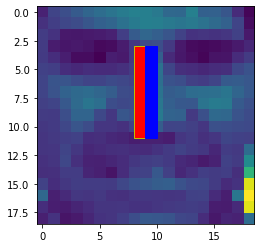

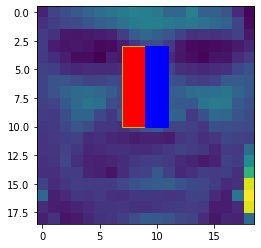

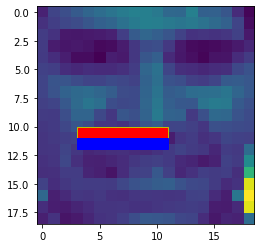

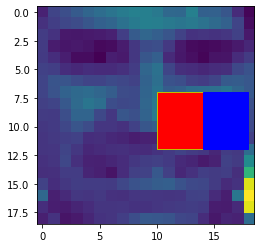

In [31]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import numpy as np
%matplotlib inline

im = trainData[2101][0]

show_clf_detail(model, check_round, im)


In [20]:
im = trainData[2101][0]
print(im.max())

0.9725490196078431
